## Time Series Forecasting

A survey of statistical and deep learning models

## What's a time series

A set of observations at regular time steps

In [72]:
from IPython.display import IFrame

# Source: https://data.gov.sg/dataset/hdb-resale-price-index
print("HDB Resale Price Index (Univariate)")
IFrame('https://data.gov.sg/dataset/hdb-resale-price-index/resource/52e93430-01b7-4de0-80df-bc83d0afed40/view/14c47d07-1395-4661-8466-728abce27f5f', width=600, height=400)

HDB Resale Price Index (Univariate)


In [73]:
from IPython.display import IFrame

# Source: https://data.gov.sg/dataset/average-weekly-paid-hours-worked-per-employee-by-industry-and-type-of-employment-annual
print("Annual Average Weekly Paid Hours Worked Per Employee, By Industry And Type Of Employment (Multi-variate)")
IFrame('https://data.gov.sg/dataset/average-weekly-paid-hours-worked-per-employee-by-industry-and-type-of-employment-annual/resource/dd2147ce-20b7-401c-ac8f-8dbcc0d8e0d9/view/431f44b1-e58d-4131-998d-7e7aeee14479', width='600', height='400')

Annual Average Weekly Paid Hours Worked Per Employee, By Industry And Type Of Employment (Multi-variate)


## Time Series Decomposition

- For analysis
- Split into trend, cyclic, seasonal, noise
- Multiplicative or additive

## Walkthrough: Time Series Decomposition
1. Go to https://data.gov.sg/dataset/hdb-resale-price-index
2. Click on the `Download` button
3. Unzip and extract the `.csv` file. Note that path to that file for use later.

We will use the [StatsModels](https://www.statsmodels.org/stable/index.html) Python library to perform the decomposition. 

This library will also be used later to perform statistical analysis. [Pandas](https://pandas.pydata.org/pandas-docs/stable/timeseries.html) is also useful for manipulating time series data.

In [28]:
"""Walkthrough: Time Series Decomposition"""

#!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import pandas as pd

# ==================================================================
# Update this path to match your actual path
data_path = 'D:\\tmp\\hdb-resale-price-index\\housing-and-development-board-resale-price-index-1q2009-100-quarterly.csv'

# load data
df = pd.read_csv(data_path)

# print first few rows
df.head(5)

,quarter,index
0,1990-Q1,24.3
1,1990-Q2,24.4
2,1990-Q3,25.0
3,1990-Q4,24.7
4,1991-Q1,24.9


### Setting the DateTimeIndex

From the table above, we can confirm it is indeed a quarterly distribution. 

`seasonal_decompose` ([docs](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)) expects a DateTimeIndex to indicate the frequency of the time series. 

To do this, we set the `DataFrame.index` property as a `pandas.DatetimeIndex` ([docs](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#generating-ranges-of-timestamps)) with a quarterly frequency.

In [58]:
num_data_entries = df.shape[0]

# generate a date range with a quarter end frequency
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases
start = pd.datetime(1990, 1, 1)
dr = pd.date_range(start, periods=num_data_entries, freq='Q')

# set the DataFrame.index
df.index = pd.DatetimeIndex(dr)

# print again to make sure the index and 'quarter' columns match
df.head(5)

,quarter,index
1990-03-31,1990-Q1,24.3
1990-06-30,1990-Q2,24.4
1990-09-30,1990-Q3,25.0
1990-12-31,1990-Q4,24.7
1991-03-31,1991-Q1,24.9


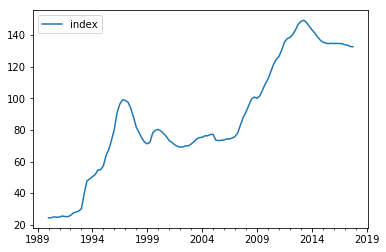

In [59]:
# plot the raw data, how that we have a DatetimeIndex
ax = df.plot()

## Seasonal Decompose

Now we are ready to decompose.  Let's try two models: `additive` and `multiplicative`.

You can find the definitions in the [StatsModels documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html), but in a nutshell, the `additive` model "adds up" the components, while the `multiplicative` model "multiplies" the components together.

Additive: $$y(t) = Trend + Seasonal + Residual$$

Mulplicative: $$y(t) = Trend * Seasonal * Residual$$

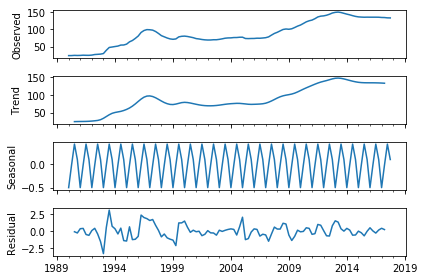

In [66]:
# it's a bit confusing, but `index` here refers to the HDB resale price index,
# not the DataFrame.index (for time series)
additive = seasonal_decompose(df.get('index'), model='additive')
additive.plot()
plt.show()

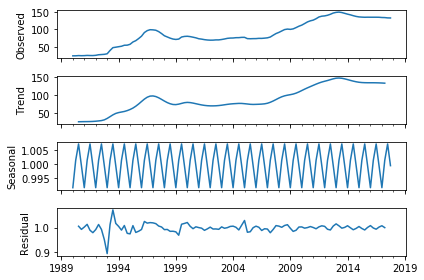

In [69]:
multiplicative = seasonal_decompose(df.get('index'), model='multiplicative')
multiplicative.plot()
plt.show()

## Observations

- There is a strong seasonal component. The component values are available as part of the object returned by `seasonal_decompose`
- The multiplicative model seems like a better fit, because the resulting residuals are smaller. In general, residuals (noise) are difficult to fit statistically.

In [71]:
# print out the first few elements of each seasonal component
print('Multiplicative model: Seasonal component')
print(multiplicative.seasonal[:10])

print('Additive model: Seasonal component')
print(additive.seasonal[:10])

Multiplicative model: Seasonal component
1990-03-31    0.991657
1990-06-30    1.001456
1990-09-30    1.007333
1990-12-31    0.999553
1991-03-31    0.991657
1991-06-30    1.001456
1991-09-30    1.007333
1991-12-31    0.999553
1992-03-31    0.991657
1992-06-30    1.001456
Freq: Q-DEC, Name: index, dtype: float64
Additive model: Seasonal component
1990-03-31   -0.500694
1990-06-30   -0.021528
1990-09-30    0.425231
1990-12-31    0.096991
1991-03-31   -0.500694
1991-06-30   -0.021528
1991-09-30    0.425231
1991-12-31    0.096991
1992-03-31   -0.500694
1992-06-30   -0.021528
Freq: Q-DEC, Name: index, dtype: float64
